## 1. Importing modules and functions
         
    

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing
import csv
import pickle

from stats import *
from calc_rdkit import *
from rename_descriptors import *
from BalanceBySim import *

from math import floor
from collections import Counter

from rdkit import Chem
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem import AllChem, Descriptors, Crippen, MolSurf, Lipinski, Fragments, EState, GraphDescriptors
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.model_selection import permutation_test_score, StratifiedKFold
from sklearn import metrics
from sklearn.externals import joblib

def warn(*args, **kwargs):
    pass  # to suppress sklearn warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn = warn

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
%reload_ext autoreload
%autoreload 2
Draw.DrawingOptions.atomLabelFontFace = "DejaVu Sans"
Draw.DrawingOptions.atomLabelFontSize = 18

# 2. Import screening data

In [2]:
# Set file path and format
file = 'curated_data/Test.sdf'

# Read SDF
sdfInfo = dict(smilesName='SMILES', molColName='ROMol')
moldf = PandasTools.LoadSDF(file, **sdfInfo);
#print('Original data: ', moldf.shape)
# Rename ROMol
moldf = moldf.rename(columns={'ROMol': 'Mol'})
# Remove missing RDKit molecules
moldf = moldf[pd.notnull(moldf['Mol'])]
if 'StandardizerResult' in moldf.columns:
    moldf = moldf.drop(columns='StandardizerResult')

RDKit WARNING: [21:50:47] Warning: conflicting stereochemistry at atom 2 ignored.
RDKit WARNING: [21:50:47] Warning: conflicting stereochemistry at atom 2 ignored.
RDKit WARNING: [21:50:47] Warning: conflicting stereochemistry at atom 25 ignored.
RDKit WARNING: [21:50:47] Warning: conflicting stereochemistry at atom 25 ignored.
RDKit WARNING: [21:50:47] Warning: conflicting stereochemistry at atom 48 ignored.
RDKit WARNING: [21:50:47] Warning: conflicting stereochemistry at atom 48 ignored.
RDKit WARNING: [21:50:47] Warning: conflicting stereochemistry at atom 22 ignored.
RDKit WARNING: [21:50:47] Warning: conflicting stereochemistry at atom 22 ignored.
RDKit WARNING: [21:50:47] Warning: conflicting stereochemistry at atom 3 ignored.
RDKit WARNING: [21:50:47] Warning: conflicting stereochemistry at atom 3 ignored.
RDKit WARNING: [21:50:47] Warning: conflicting stereochemistry at atom 12 ignored.
RDKit WARNING: [21:50:47] Warning: conflicting stereochemistry at atom 12 ignored.
RDKit WA

Kept data:  (835, 4)


,Compound_name,ID,Mol,SMILES
0,ext_1,,,CCS(=O)(=O)N1CC(CC#N)(n2cc(-c3ncnc4[nH]ccc34)cn2)C1

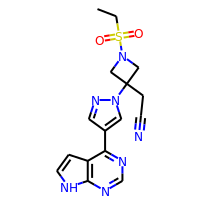


 Problematic structures: 
 []


In [3]:
# Columns
print('Kept data: ', moldf.shape)
moldf.head(1)
from molvs.validate import Validator
fmt = '%(asctime)s - %(levelname)s - %(validation)s - %(message)s'
validator = Validator(log_format=fmt)
print('\n Problematic structures: \n', validator.validate(moldf))

# 3. Calculate descriptors

##### Calculate descriptors using custom function

In [4]:
rdkit_vs = moldf.Mol.apply(calc_rdkit)
rdkit_vs = rename_descriptors(rdkit_vs)
rdkit_vs = rdkit_vs.astype(float).round(2)
rdkit_vs.head()

,MolLogP,MolMR,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,FractionCSP3,HeavyAtomMolWt,MaxAbsPartialCharge,MaxPartialCharge,MinAbsPartialCharge,MinPartialCharge,MolWt,NumRadicalElectrons,NumValenceElectrons,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_ArN,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_COO,fr_COO2,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_HOCCN,fr_imidazole,fr_imide,fr_Imine,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_NH0,fr_NH1,fr_NH2,fr_Nhpyrrole,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_SH,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,TPSA
0,1.10,94.35,1.38,2.19,2.92,0.38,354.29,0.35,0.21,0.21,-0.35,371.43,0.0,134.0,12.04,12.04,0.05,-3.27,15.56,13.68,0.0,25.26,0.00,22.29,10.63,24.00,12.26,26.12,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.69,1103.02,18.36,14.12,14.94,12.49,8.17,9.78,6.36,8.62,4.80,6.58,3.28,4.52,-2.77,1.034201e+06,16.69,5.89,2.48,26.0,1.0,9.0,0.0,1.0,1.0,0.0,3.0,3.0,7.0,1.0,10.0,5.0,0.0,1.0,1.0,4.0,149.89,4.98,17.51,0.00,10.02,0.00,0.00,4.68,18.39,14.67,0.0,0.00,12.99,36.43,30.13,0.00,0.00,0.0,0.0,56.30,15.56,11.33,13.34,30.98,0.0,22.29,0.0,8.42,21.06,5.26,29.04,0.00,18.88,18.84,30.98,0.0,17.33,120.56
1,2.77,111.78,1.24,2.00,2.69,0.38,373.26,0.38,0.21,0.21,-0.38,399.47,0.0,154.0,13.51,13.51,0.27,-1.09,12.46,9.18,0.0,11.51,29.75,30.64,6.33,11.68,31.19,15.28,10.47,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,2.08,984.90,20.80,16.74,16.74,14.08,9.57,9.57,6.85,6.85,4.81,4.81,3.43,3.43,-2.84,4.085494e+06,20.88,9.58,4.44,29.0,3.0,7.0,0.0,0.0,0.0,1.0,2.0,3.0,7.0,2.0,8.0,10.0,0.0,0.0,0.0,3.0,168.64,20.35,17.79,6.67,5.78,0.00,0.00,4.79,14.36,0.00,0.0,29.83,25.45,25.76,17.69,11.05,10.21,0.0,0.0,53.80,11.28,6.92,22.47,30.59,0.0,22.16,0.0,13.92,22.63,0.00,19.85,0.00,19.89,39.21,41.85,0.

##### Calculate morgan fingerprints with 2048 bits and radius 3

In [5]:
def calcfp(mol,funcFPInfo=dict(radius=3, nBits=2048, useFeatures=False, useChirality = False)):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, **funcFPInfo)
    fp = pd.Series(np.asarray(fp))
    fp = fp.add_prefix('Bit_')
    return fp

morgan_vs = moldf.Mol.apply(calcfp)

In [6]:
X_vs = pd.concat([rdkit_vs, morgan_vs], axis=1, join='inner').reset_index(drop=True)
X_vs.shape

(835, 2236)

##### Clean descriptors

In [7]:
# Load model's descriptors
model_descriptors = pd.read_csv('descriptors/rdkit_morgan.csv.gz', index_col=0)

# Filter out descriptors not present in the model
descriptor_list = list(model_descriptors.columns.values)
X_vs = X_vs[descriptor_list]
X_vs.shape

(835, 2136)

## 4. Virtual screening

##### Load the model

In [8]:
from sklearn.externals import joblib
model = joblib.load('model/rf_rdkit_morgan.pkl')

##### Predict molecules

In [10]:
%%time
ad_threshold = 0.6

y_pred = model.predict(X_vs)
ad = model.predict_proba(X_vs)
ad = np.amax(ad, axis=1) >= ad_threshold

CPU times: user 180 ms, sys: 0 ns, total: 180 ms
Wall time: 179 ms


In [11]:
pred = pd.DataFrame({'Prediction': y_pred,'AD': ad}, index=None)
pred.AD[pred.AD == False] = np.nan
pred.AD[pred.AD == True] = pred.Prediction.astype(int)

In [12]:
pred_ad = pred.dropna().astype(int)
coverage_ad = len(pred_ad) * 100 / len(pred)

print('VS pred: %s' % Counter(pred.Prediction))
print('VS pred AD: %s' % Counter(pred_ad.Prediction))
print('Coverage of AD: %.2f%%' % coverage_ad)

VS pred: Counter({0: 646, 1: 189})
VS pred AD: Counter({0: 400, 1: 80})
Coverage of AD: 57.49%


##  5. Exporting predictions

In [13]:
predictions = pd.concat([moldf, pred], axis=1)
predictions = predictions[['Compound_name', 'Prediction', 'AD']]
predictions.head()

,Compound_name,Prediction,AD
0,ext_1,0,0.0
1,ext_2,0,0.0
2,ext_3,0,0.0
3,ext_4,0,NaN
4,ext_5,0,0.0


In [14]:
predictions.to_csv('Test_pred-herg.csv')